# Compare Rustody - vs - BD Results

I hope that this will now show that my tool does work...

In [1]:
! quantify_rhapsody_multi -h

rustody 1.2.5
Stefan L. <stefan.lang@med.lu.se>
Quantifies a DB Rhapsody experiment and creates sparse matrix outfiles. You need quite long R1 and
R2 reads for this! (>70R1 and >70R2 \[v1\] and 52 bp reads for v2.96 and v2.384)

USAGE:
    quantify_rhapsody_multi [OPTIONS] --reads <READS> --file <FILE> --specie <SPECIE> --outpath <OUTPATH> --min-umi <MIN_UMI> --version <VERSION>

OPTIONS:
    -a, --antibody <ANTIBODY>          the fasta database containing the antibody tags
    -e, --expression <EXPRESSION>      the fasta database containing the genes
        --exp <EXP>                    this is a BD rhapsody or a 10x expression experiment?
                                       [default: bd]
    -f, --file <FILE>                  the input R2 samples file
        --gene-kmers <GENE_KMERS>      minimal sequencing quality [default: 32]
    -h, --help                         Print help information
    -i, --index <INDEX>                a pre-defined index folder produced by the cerateI

In [2]:
%load_ext autotime

import scvelo as scv
import loompy
import scanpy
import igraph
import phate
import glob, os
import pandas as pd
import os
import re
import subprocess
from collections import Counter
import numpy as np
from shutil import rmtree
import os
import anndata

import h5py
from shutil import copyfile


def copyFiles(files, to):
    for f in files:
        name = os.path.basename( f )
        print( f"copy {f} to {to}" )
        copyfile( f, os.path.join(to, name ) )
    print( "all copied" )

time: 2.32 s (started: 2024-01-26 15:24:48 +01:00)


In [3]:
exe = "quantify_rhapsody_multi"
R1 = ["/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L004_R1_001.fastq.gz"
      ,"/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L003_R1_001.fastq.gz"
      ,"/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L001_R1_001.fastq.gz"
      ,"/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L002_R1_001.fastq.gz"
     ]
r1 = ",".join(R1)
R2 = [ "/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L004_R2_001.fastq.gz"
      ,"/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L002_R2_001.fastq.gz"
      ,"/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L001_R2_001.fastq.gz"
      ,"/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L003_R2_001.fastq.gz"
]
r2 = ",".join(R2)
out = "/mnt/data2/RhapsodyTest/VDJ_v1_example/rustify_testData_result"
exp = "/mnt/data2/RhapsodyTest/VDJ_v1_example/BD_Rhapsody_Immune_Response_Panel_Hs.fasta"

! {exe} -r {r1} -f {r2} -o {out} -s human -e {exp} -m 200 -v 'v1' 1>&2

Analysis will stop after having processed 18446744073709551615 fastq entries containing a cell info

init models
the log file: Mapping_log.txt
Changing the expression start gene id to 398
After indexing all fastq files we have the following indices:
the mRNA index:
I have 41210 kmers for 398 genes with 0.16652039% duplicate entries
gene names like 'phiX174'
gene_ids range from Some(0) to Some(397)

the sample id index:
I have 384 kmers for 12 genes with 0% duplicate entries
gene names like 'Sample12'
gene_ids range from Some(398) to Some(409)

and the antibodies index:
This index is empty

Writing index version 6
with kmer_len 32
And a total of 41210 data entries

Parsing file pair 1

I am using 12 cpus
   1.90 mio reads (62.68% with cell_id, 61.58% with gene_id)                    
Parsing file pair 2

I am using 12 cpus
   3.83 mio reads (64.21% with cell_id, 62.95% with gene_id)                    
Parsing file pair 3

I am using 12 cpus
   5.79 mio reads (64.03% with cell_id, 62.81

In [4]:
BD_Data =  anndata.read( 'BD-Demo-VDJ/RhapVDJDemo-BCR.h5ad')
BD_Data

AnnData object with n_obs × n_vars = 2723 × 367
    obs: 'Cell_Type_Experimental', 'Total_VDJ_Read_Count', 'Total_VDJ_Molecule_Count', 'BCR_Heavy_V_gene_Dominant', 'BCR_Heavy_D_gene_Dominant', 'BCR_Heavy_J_gene_Dominant', 'BCR_Heavy_C_gene_Dominant', 'BCR_Heavy_CDR3_Nucleotide_Dominant', 'BCR_Heavy_CDR3_Translation_Dominant', 'BCR_Heavy_Read_Count', 'BCR_Heavy_Molecule_Count', 'BCR_Light_V_gene_Dominant', 'BCR_Light_J_gene_Dominant', 'BCR_Light_C_gene_Dominant', 'BCR_Light_CDR3_Nucleotide_Dominant', 'BCR_Light_CDR3_Translation_Dominant', 'BCR_Light_Read_Count', 'BCR_Light_Molecule_Count', 'TCR_Alpha_Gamma_V_gene_Dominant', 'TCR_Alpha_Gamma_J_gene_Dominant', 'TCR_Alpha_Gamma_C_gene_Dominant', 'TCR_Alpha_Gamma_CDR3_Nucleotide_Dominant', 'TCR_Alpha_Gamma_CDR3_Translation_Dominant', 'TCR_Alpha_Gamma_Read_Count', 'TCR_Alpha_Gamma_Molecule_Count', 'TCR_Beta_Delta_V_gene_Dominant', 'TCR_Beta_Delta_D_gene_Dominant', 'TCR_Beta_Delta_J_gene_Dominant', 'TCR_Beta_Delta_C_gene_Dominant', 'TCR_Beta_

time: 96.1 ms (started: 2024-01-26 15:26:33 +01:00)


In [5]:
def readRustodyExpression(path, name):
    print(f"reading Rustody expression from path {path}/BD_Rhapsody_expression/")
    this = scanpy.read_10x_mtx( path+'/BD_Rhapsody_expression/' )
    this.obs['sample'] = name
    obs1 = pd.read_csv( path+'/SampleCounts.tsv', sep="\t")
    this.obs = this.obs.merge( obs1, left_index= True, right_on = 'CellID' )
    this.obs_names = this.obs['CellID'] + "_" +  this.obs['sample']#
    # we have no sample info here - this whole data is one sample!
    #this = this[this.obs['AsignedSampleName'] != "na"]
    this.obs['AsignedSampleName'] = this.obs['AsignedSampleName'] + "_" + this.obs['sample']
    return(this)

time: 670 µs (started: 2024-01-26 15:26:34 +01:00)


In [6]:
out = "/mnt/data2/RhapsodyTest/VDJ_v1_example/rustify_testData_result/"

time: 4.32 ms (started: 2024-01-26 15:26:34 +01:00)


In [7]:
Rustody_Data = readRustodyExpression( out, 'VDJ_Example_Data')
Rustody_Data

reading Rustody expression from path /mnt/data2/RhapsodyTest/VDJ_v1_example/rustify_testData_result//BD_Rhapsody_expression/


AnnData object with n_obs × n_vars = 2768 × 367
    obs: 'sample', 'CellID', 'Sample1', 'Sample2', 'Sample3', 'Sample4', 'Sample5', 'Sample6', 'Sample7', 'Sample8', 'Sample9', 'Sample10', 'Sample11', 'Sample12', 'AsignedSampleName', 'FractionTotal', 'n'
    var: 'gene_ids', 'feature_types'

time: 677 ms (started: 2024-01-26 15:26:34 +01:00)


In [8]:
Rustody_Data.obs['source'] = "Rustody_v1.2.5"
BD_Data.obs['source'] = "BD_version1"

time: 701 µs (started: 2024-01-26 15:26:34 +01:00)


In [9]:
BD_Data.obs_names[1:10]

Index(['2758', '3516', '7707', '8497', '8834', '10464', '12348', '12375',
       '13522'],
      dtype='object')

time: 12.5 ms (started: 2024-01-26 15:26:34 +01:00)


In [10]:
Rustody_Data.obs_names[1:10]

Index(['Cell2758_VDJ_Example_Data', 'Cell3516_VDJ_Example_Data',
       'Cell7707_VDJ_Example_Data', 'Cell8497_VDJ_Example_Data',
       'Cell8834_VDJ_Example_Data', 'Cell10464_VDJ_Example_Data',
       'Cell12348_VDJ_Example_Data', 'Cell12375_VDJ_Example_Data',
       'Cell13522_VDJ_Example_Data'],
      dtype='object')

time: 2.87 ms (started: 2024-01-26 15:26:34 +01:00)


In [11]:
pattern = re.compile(r'-[01]$')
BD_Data.obs['Rustody_Names'] = [ "Cell"+str( int(pattern.sub('',BD_Data.obs_names.values[id]))) +"_"+ "VDJ_Example_Data" for id in range( len(BD_Data.obs_names))]

time: 3.82 ms (started: 2024-01-26 15:26:34 +01:00)


In [12]:
BD_Data.obs['Rustody_Names'][1:10]

2758      Cell2758_VDJ_Example_Data
3516      Cell3516_VDJ_Example_Data
7707      Cell7707_VDJ_Example_Data
8497      Cell8497_VDJ_Example_Data
8834      Cell8834_VDJ_Example_Data
10464    Cell10464_VDJ_Example_Data
12348    Cell12348_VDJ_Example_Data
12375    Cell12375_VDJ_Example_Data
13522    Cell13522_VDJ_Example_Data
Name: Rustody_Names, dtype: object

time: 3.06 ms (started: 2024-01-26 15:26:34 +01:00)


In [13]:
Counter( [name in Rustody_Data.obs_names for name in BD_Data.obs['Rustody_Names']] )

Counter({True: 2722, False: 1})

time: 4.75 ms (started: 2024-01-26 15:26:34 +01:00)


In [14]:
Counter( [name in BD_Data.obs['Rustody_Names'].values for name in Rustody_Data.obs_names ] )

Counter({True: 2722, False: 46})

time: 108 ms (started: 2024-01-26 15:26:34 +01:00)


In [15]:
Rustody_Data = Rustody_Data[[ name for name in BD_Data.obs['Rustody_Names'] if name in Rustody_Data.obs_names]]

time: 8.1 ms (started: 2024-01-26 15:26:34 +01:00)


In [16]:
BD_Data= BD_Data [BD_Data.obs['Rustody_Names'].isin( [ name  for name in BD_Data.obs['Rustody_Names'] if name in Rustody_Data.obs_names] )]

time: 12.7 ms (started: 2024-01-26 15:26:34 +01:00)


In [17]:
[name for name in BD_Data.var_names if name not in Rustody_Data.var_names ]

['CCL1', 'CCL2', 'IL1RL1', 'IL5']

time: 1.57 ms (started: 2024-01-26 15:26:34 +01:00)


In [18]:
[name for name in Rustody_Data.var_names if name not in BD_Data.var_names ]

['CHI3L1', 'IL22', 'ZBED2', 'phiX174']

time: 2.24 ms (started: 2024-01-26 15:26:34 +01:00)


In [19]:
from scipy.stats.stats import pearsonr   

time: 2.29 ms (started: 2024-01-26 15:26:34 +01:00)


In [20]:
BD_Data.obs_names

Index(['1229', '2758', '3516', '7707', '8497', '8834', '10464', '12348',
       '12375', '13522',
       ...
       '14019899', '14022966', '14030253', '14031393', '14032909', '14036049',
       '14039502', '14042139', '14042509', '14043327'],
      dtype='object', length=2722)

time: 3.3 ms (started: 2024-01-26 15:26:34 +01:00)


In [21]:
Rustody_Data.obs_names

Index(['Cell1229_VDJ_Example_Data', 'Cell2758_VDJ_Example_Data',
       'Cell3516_VDJ_Example_Data', 'Cell7707_VDJ_Example_Data',
       'Cell8497_VDJ_Example_Data', 'Cell8834_VDJ_Example_Data',
       'Cell10464_VDJ_Example_Data', 'Cell12348_VDJ_Example_Data',
       'Cell12375_VDJ_Example_Data', 'Cell13522_VDJ_Example_Data',
       ...
       'Cell14019899_VDJ_Example_Data', 'Cell14022966_VDJ_Example_Data',
       'Cell14030253_VDJ_Example_Data', 'Cell14031393_VDJ_Example_Data',
       'Cell14032909_VDJ_Example_Data', 'Cell14036049_VDJ_Example_Data',
       'Cell14039502_VDJ_Example_Data', 'Cell14042139_VDJ_Example_Data',
       'Cell14042509_VDJ_Example_Data', 'Cell14043327_VDJ_Example_Data'],
      dtype='object', length=2722)

time: 3.39 ms (started: 2024-01-26 15:26:34 +01:00)


In [22]:
cmp = pd.DataFrame(
    [ pearsonr( np.array(BD_Data[:,gene].X.todense()).flatten(), np.array( Rustody_Data[:,gene].X.todense()).flatten() ) for gene in Rustody_Data.var_names if gene in BD_Data.var_names ]  )
cmp['gname'] = [gene  for gene in Rustody_Data.var_names if gene in BD_Data.var_names ]
cmp

,0,1,gname
0,0.571035,2.159968e-235,ADA
1,0.512823,1.739632e-182,ADGRE1
2,0.481309,7.171231e-158,ADGRG3
3,0.455430,1.686910e-139,AIM2
4,0.729737,0.000000e+00,ANXA5
...,...,...,...
358,0.749973,0.000000e+00,XBP1
359,0.689096,0.000000e+00,YBX3
360,0.336809,3.458320e-73,ZAP70
361,0.417928,1.516947e-115,ZBTB16


time: 2.51 s (started: 2024-01-26 15:26:34 +01:00)


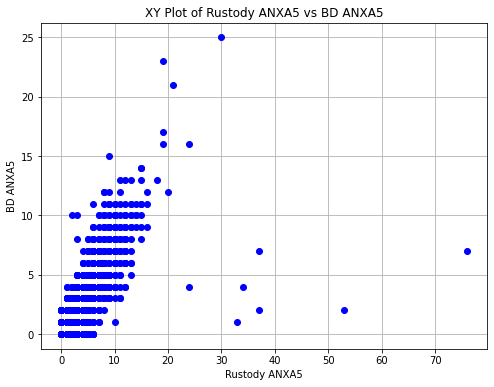

time: 104 ms (started: 2024-01-26 15:26:37 +01:00)


In [23]:
gname = "ANXA5"
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(Rustody_Data[:,gname].X.todense(), BD_Data[:,gname].X.todense(), 'o', color='blue')  # 'o' represents marker style, you can change it as needed
plt.xlabel( f"Rustody {gname}" )
plt.ylabel( f"BD {gname}" )
plt.title( f"XY Plot of Rustody {gname} vs BD {gname}" )
plt.grid(True)
plt.show()

In [24]:
Rustody_Data [Rustody_Data[:, 'ADA'].X > 40,:'ADA'].X.todense()

matrix([[43.]], dtype=float32)

time: 5.95 ms (started: 2024-01-26 15:26:37 +01:00)


In [25]:
BD_Data ['6206212',:'ADA'].X.todense()

matrix([[1]])

time: 6.44 ms (started: 2024-01-26 15:26:37 +01:00)


In [26]:
Rustody_Data [Rustody_Data[:, 'ADA'].X > 40].obs_names


Index(['Cell6206212_VDJ_Example_Data'], dtype='object')

time: 4.65 ms (started: 2024-01-26 15:26:37 +01:00)


In [27]:
! bd_get_single_cell -hCTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGAACTCA

rustody 0.1.1
Stefan L. <stefan.lang@med.lu.se>

USAGE:
    bd_get_single_cell --reads <READS> --file <FILE> --id <ID> --outpath <OUTPATH> --version <VERSION>

OPTIONS:
    -f, --file <FILE>          the input R2 samples file
    -h, --help                 Print help information
    -i, --id <ID>              the specie of the library [mouse, human]
    -o, --outpath <OUTPATH>    the outpath
    -r, --reads <READS>        the input R1 reads file
    -v, --version <VERSION>    the version of beads you used v1, v2.96 or v2.384
time: 127 ms (started: 2024-01-26 15:26:37 +01:00)


In [28]:
print ( f"bd_get_single_cell -r {R1[0]} -f {R2[0]} -i 6206212 -o {out} -v v1")
! bd_get_single_cell -r {R1[0]} -f {R2[0]} -i 6206212 -o {out} -v v1

bd_get_single_cell -r /mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L004_R1_001.fastq.gz -f /mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L004_R2_001.fastq.gz -i 6206212 -o /mnt/data2/RhapsodyTest/VDJ_v1_example/rustify_testData_result/ -v v1
writing all reads from the cell 6206212
[100/?] ⠠ cell read (any/6206212) 1200000/16720 here I have cell 3835448        I found 17348 reads for the cell 6206212
time: 34.6 s (started: 2024-01-26 15:26:37 +01:00)


# These likely contain something else

Now Any gene detected. Likely the Igh and TCR reads.

In [29]:
print ( f"bd_get_single_cell -r {R1[0]} -f {R2[0]} -i 6206212 -o {out} -v v1")
! bd_get_single_cell -r {R1[1]} -f {R2[1]} -i 6206212 -o {out} -v v1

bd_get_single_cell -r /mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L004_R1_001.fastq.gz -f /mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L004_R2_001.fastq.gz -i 6206212 -o /mnt/data2/RhapsodyTest/VDJ_v1_example/rustify_testData_result/ -v v1
writing all reads from the cell 6206212
[100/?] ⠐ cell read (any/6206212) 1300000/17426 here I have cell 596373         I found 17897 reads for the cell 6206212
time: 31.9 s (started: 2024-01-26 15:27:12 +01:00)


## Finding matched to ADA

I have modified my quantify_rhapsody_multi to report ADA matches and got these matches in the R1[1] R2[1] pair:

```
"CTGAGGAGTCACCCCAACTCTGTGCGCCTGAGCAACATTTTTACAATTATTCATACCAAGAAGACAAAGATATCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGGTCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATATTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACAATTATTCCTTCAAAGAATACAATGATATAA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGTAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAGCATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
```

There are some single nucleotide polimorphisms - but the sequence matches to ADA using online NCBI-Blast.


In [30]:
print ( f"bd_get_single_cell -r {R1[2]} -f {R2[2]} -i 6206212 -o {out} -v v1")
! bd_get_single_cell -r {R1[2]} -f {R2[2]} -i 6206212 -o {out} -v v1

bd_get_single_cell -r /mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L001_R1_001.fastq.gz -f /mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L001_R2_001.fastq.gz -i 6206212 -o /mnt/data2/RhapsodyTest/VDJ_v1_example/rustify_testData_result/ -v v1
writing all reads from the cell 6206212
[100/?] ⠐ cell read (any/6206212) 1300000/18899 here I have cell 8578256        I found 19115 reads for the cell 6206212
time: 34.5 s (started: 2024-01-26 15:27:44 +01:00)


# Only one read in there:

```
CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA
```

Total of 25 reads - I can not collect the UMIs without changing a lot in the logics of my Rust project - so I am not going to do that.

In [31]:
print ( f"bd_get_single_cell -r {R1[3]} -f {R2[3]} -i 6206212 -o {out} -v v1")
! bd_get_single_cell -r {R1[3]} -f {R2[3]} -i 6206212 -o {out} -v v1

bd_get_single_cell -r /mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L002_R1_001.fastq.gz -f /mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L003_R2_001.fastq.gz -i 6206212 -o /mnt/data2/RhapsodyTest/VDJ_v1_example/rustify_testData_result/ -v v1
writing all reads from the cell 6206212
[100/?] ⠐ cell read (any/6206212) 1300000/18127 here I have cell 1784458        I found 18425 reads for the cell 6206212
time: 32.1 s (started: 2024-01-26 15:28:18 +01:00)


# And more once again:

```
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGAACTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCAGTGGGGCTGAGCAAAATTTTTACATTTTATCCTTGGAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTAGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACAATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACGTTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCGAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACATTTTTACATTTATTCCTTCCAAGAAGACCATGATCTCA"
"CTGTGGAGTCACCCCAACTCTGTGGGGCTGAGCAACACTTTTACATTTATTCCTTCCAAGAAGACCATTATCTAA"
```
To a total of 43 reads in total.

In [33]:
! ls -lhrt {out}

total 47M
-rw-rw-r-- 1 med-sal med-sal    20 Jan 26 13:07  OneSingleCell.6206211.R2.fastq.gz
-rw-rw-r-- 1 med-sal med-sal    20 Jan 26 13:07  OneSingleCell.6206211.R1.fastq.gz
-rw-rw-r-- 1 med-sal med-sal  356K Jan 26 13:51  f1_OneSingleCell.6206212.R2.fastq.gz
-rw-rw-r-- 1 med-sal med-sal  414K Jan 26 13:51  f1_OneSingleCell.6206212.R1.fastq.gz
-rw-rw-r-- 1 med-sal med-sal  3.6M Jan 26 15:24  index.1.Index
-rw-rw-r-- 1 med-sal med-sal  2.4K Jan 26 15:24  index.1.gene.txt
-rw-rw-r-- 1 med-sal med-sal   23M Jan 26 15:24  index.1.Index.txt
-rw-rw-r-- 1 med-sal med-sal     0 Jan 26 15:26 'Mapping_log_ThreadId(9).txt'
-rw-rw-r-- 1 med-sal med-sal     0 Jan 26 15:26 'Mapping_log_ThreadId(8).txt'
-rw-rw-r-- 1 med-sal med-sal     0 Jan 26 15:26 'Mapping_log_ThreadId(7).txt'
-rw-rw-r-- 1 med-sal med-sal     0 Jan 26 15:26 'Mapping_log_ThreadId(6).txt'
-rw-rw-r-- 1 med-sal med-sal     0 Jan 26 15:26 'Mapping_log_ThreadId(5).txt'
-rw-rw-r-- 1 med-sal med-sal     0 Jan 26 15:26 'Mapping_log_Threa

In [34]:
np.array(Rustody_Data[:, "ADA"].X.todense()[:,0].transpose())

array([[1., 2., 1., ..., 0., 3., 1.]], dtype=float32)

time: 8.06 ms (started: 2024-01-26 15:29:37 +01:00)


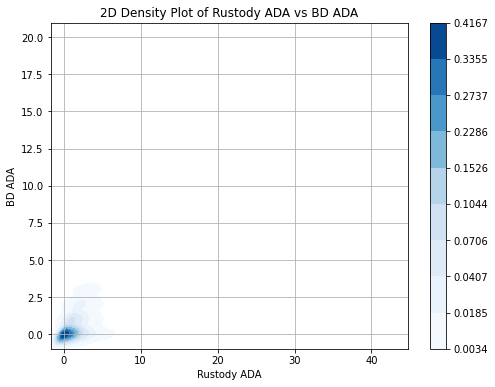

time: 2.12 s (started: 2024-01-26 15:29:38 +01:00)


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming Rustody_Data and BD_Data are pandas DataFrames
# Assuming you want to plot the "ADA" column from both DataFrames

# Extracting data from the "ADA" column
rustody_x = np.array(Rustody_Data[:, "ADA"].X.todense()[:,0].transpose()).ravel()
bd_x = np.array(BD_Data[:, "ADA"].X.todense()[:,0].transpose()).ravel()

# Creating the 2D density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(rustody_x, bd_x, cmap="Blues", shade=True, cbar=True)
plt.xlabel('Rustody ADA')
plt.ylabel('BD ADA')
plt.title('2D Density Plot of Rustody ADA vs BD ADA')
plt.grid(True)
plt.show()

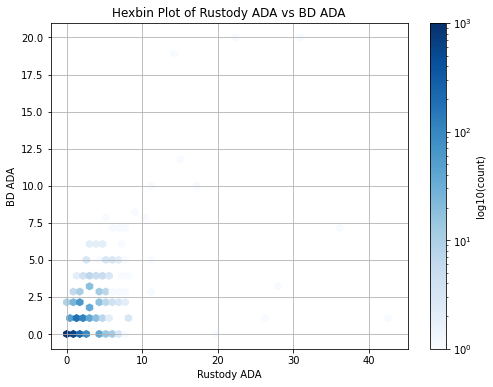

time: 279 ms (started: 2024-01-26 15:29:40 +01:00)


In [36]:
import matplotlib.pyplot as plt

# Assuming Rustody_Data and BD_Data are pandas DataFrames
# Assuming you want to plot the "ADA" column from both DataFrames

# Extracting data from the "ADA" column
rustody_x = np.array(Rustody_Data[:, "ADA"].X.todense()[:,0].transpose()).ravel()
bd_x = np.array(BD_Data[:, "ADA"].X.todense()[:,0].transpose()).ravel()

# Creating the hexbin plot
plt.figure(figsize=(8, 6))
plt.hexbin(rustody_x, bd_x, gridsize=50, cmap='Blues', bins='log')
plt.colorbar(label='log10(count)')
plt.xlabel('Rustody ADA')
plt.ylabel('BD ADA')
plt.title('Hexbin Plot of Rustody ADA vs BD ADA')
plt.grid(True)
plt.show()

# So what if the data I got from BD is actually only looking into file 3 of 4?

As the BD data reports 1 reads for ADA in the whole data, but I really really find 43 ones in all 4 files there is a possibility that the BD exmaple data is also only looking into this one file - right?

This could hopefully also explain my horrible correlation values. Let's try with only file 3/4.

In [37]:
exe = "quantify_rhapsody_multi"
R1 = [#"/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L004_R1_001.fastq.gz"
      #,"/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L003_R1_001.fastq.gz",
      "/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L001_R1_001.fastq.gz"
      #,"/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L002_R1_001.fastq.gz"
     ]
r1 = ",".join(R1)
R2 = [ #"/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L004_R2_001.fastq.gz"
      #,"/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L002_R2_001.fastq.gz",
      "/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L001_R2_001.fastq.gz"
      #,"/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L003_R2_001.fastq.gz"
]
r2 = ",".join(R2)
out = "/mnt/data2/RhapsodyTest/VDJ_v1_example/rustify_testData_result"
exp = "/mnt/data2/RhapsodyTest/VDJ_v1_example/BD_Rhapsody_Immune_Response_Panel_Hs.fasta"

! {exe} -r {r1} -f {r2} -o {out} -s human -e {exp} -m 20 -v 'v1' 1>&2

Analysis will stop after having processed 18446744073709551615 fastq entries containing a cell info

init models
the log file: Mapping_log.txt
Changing the expression start gene id to 398
After indexing all fastq files we have the following indices:
the mRNA index:
I have 41210 kmers for 398 genes with 0.16652039% duplicate entries
gene names like 'phiX174'
gene_ids range from Some(0) to Some(397)

the sample id index:
I have 384 kmers for 12 genes with 0% duplicate entries
gene names like 'Sample12'
gene_ids range from Some(398) to Some(409)

and the antibodies index:
This index is empty

Writing index version 6
with kmer_len 32
And a total of 41210 data entries

Parsing file pair 1

I am using 12 cpus
   1.97 mio reads (63.67% with cell_id, 62.53% with gene_id)                    

Writing outfiles ...
filtering cells
Dropping cell with too little counts (n=74294)
3015 cells have passed the cutoff of 20 umi counts per cell.


writing gene expression
sparse Matrix: 3015 cell(s), 357 g

In [38]:
Rustody_Data = readRustodyExpression( out, 'VDJ_Example_Data')
Rustody_Data

reading Rustody expression from path /mnt/data2/RhapsodyTest/VDJ_v1_example/rustify_testData_result/BD_Rhapsody_expression/


AnnData object with n_obs × n_vars = 3015 × 357
    obs: 'sample', 'CellID', 'Sample1', 'Sample2', 'Sample3', 'Sample4', 'Sample5', 'Sample6', 'Sample7', 'Sample8', 'Sample9', 'Sample10', 'Sample11', 'Sample12', 'AsignedSampleName', 'FractionTotal', 'n'
    var: 'gene_ids', 'feature_types'

time: 254 ms (started: 2024-01-26 15:30:06 +01:00)


In [39]:
Rustody_Data = Rustody_Data[[ name for name in BD_Data.obs['Rustody_Names'] if name in Rustody_Data.obs_names]]

time: 4.72 ms (started: 2024-01-26 15:30:06 +01:00)


In [40]:
[name for name in BD_Data.var_names if name not in Rustody_Data.var_names ]

['CCL1',
 'CCL2',
 'CCL22',
 'CD80',
 'CTSG',
 'IL13',
 'IL1RL1',
 'IL5',
 'LRRC32',
 'MME',
 'MMP9']

time: 3.57 ms (started: 2024-01-26 15:30:06 +01:00)


In [41]:
print(Rustody_Data)

View of AnnData object with n_obs × n_vars = 2722 × 357
    obs: 'sample', 'CellID', 'Sample1', 'Sample2', 'Sample3', 'Sample4', 'Sample5', 'Sample6', 'Sample7', 'Sample8', 'Sample9', 'Sample10', 'Sample11', 'Sample12', 'AsignedSampleName', 'FractionTotal', 'n'
    var: 'gene_ids', 'feature_types'
time: 2.13 ms (started: 2024-01-26 15:30:06 +01:00)


In [42]:
print(BD_Data)

View of AnnData object with n_obs × n_vars = 2722 × 367
    obs: 'Cell_Type_Experimental', 'Total_VDJ_Read_Count', 'Total_VDJ_Molecule_Count', 'BCR_Heavy_V_gene_Dominant', 'BCR_Heavy_D_gene_Dominant', 'BCR_Heavy_J_gene_Dominant', 'BCR_Heavy_C_gene_Dominant', 'BCR_Heavy_CDR3_Nucleotide_Dominant', 'BCR_Heavy_CDR3_Translation_Dominant', 'BCR_Heavy_Read_Count', 'BCR_Heavy_Molecule_Count', 'BCR_Light_V_gene_Dominant', 'BCR_Light_J_gene_Dominant', 'BCR_Light_C_gene_Dominant', 'BCR_Light_CDR3_Nucleotide_Dominant', 'BCR_Light_CDR3_Translation_Dominant', 'BCR_Light_Read_Count', 'BCR_Light_Molecule_Count', 'TCR_Alpha_Gamma_V_gene_Dominant', 'TCR_Alpha_Gamma_J_gene_Dominant', 'TCR_Alpha_Gamma_C_gene_Dominant', 'TCR_Alpha_Gamma_CDR3_Nucleotide_Dominant', 'TCR_Alpha_Gamma_CDR3_Translation_Dominant', 'TCR_Alpha_Gamma_Read_Count', 'TCR_Alpha_Gamma_Molecule_Count', 'TCR_Beta_Delta_V_gene_Dominant', 'TCR_Beta_Delta_D_gene_Dominant', 'TCR_Beta_Delta_J_gene_Dominant', 'TCR_Beta_Delta_C_gene_Dominant', 'T

In [43]:
cmp = pd.DataFrame(
    [ pearsonr( np.array(BD_Data[:,gene].X.todense()).flatten(), np.array( Rustody_Data[:,gene].X.todense()).flatten() ) for gene in Rustody_Data.var_names if gene in BD_Data.var_names ]  )
cmp['gname'] = [gene  for gene in Rustody_Data.var_names if gene in BD_Data.var_names ]
cmp

,0,1,gname
0,0.859934,0.000000e+00,ADA
1,0.716971,0.000000e+00,ADGRE1
2,0.697156,0.000000e+00,ADGRG3
3,0.626344,1.577742e-296,AIM2
4,0.878897,0.000000e+00,ANXA5
...,...,...,...
351,0.829147,0.000000e+00,XBP1
352,0.875166,0.000000e+00,YBX3
353,0.684185,0.000000e+00,ZAP70
354,0.523339,2.716482e-191,ZBTB16


time: 2.29 s (started: 2024-01-26 15:30:06 +01:00)


In [44]:
Rustody_Data [Rustody_Data[:, 'ADA'].X > 40].obs_names

Index([], dtype='object')

time: 3.14 ms (started: 2024-01-26 15:30:09 +01:00)


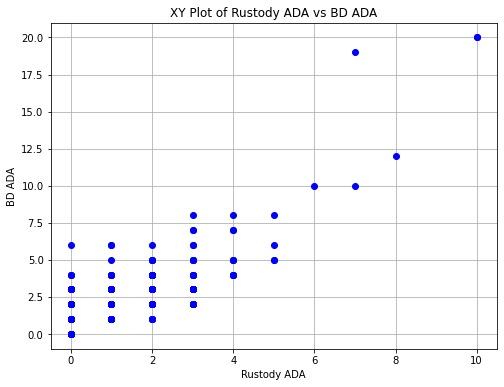

time: 101 ms (started: 2024-01-26 15:30:09 +01:00)


In [45]:
gname = "ADA"
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(Rustody_Data[:,gname].X.todense(), BD_Data[:,gname].X.todense(), 'o', color='blue')  # 'o' represents marker style, you can change it as needed
plt.xlabel( f"Rustody {gname}" )
plt.ylabel( f"BD {gname}" )
plt.title( f"XY Plot of Rustody {gname} vs BD {gname}" )
plt.grid(True)
plt.show()

# Next option : merge file 1/4 + file 3 of 4

With 0 having no ADA reads for the cell of interest.

In [46]:
exe = "quantify_rhapsody_multi"
R1 = ["/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L004_R1_001.fastq.gz",
      #"/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L003_R1_001.fastq.gz",
      "/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L001_R1_001.fastq.gz"
      #,"/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L002_R1_001.fastq.gz"
     ]
r1 = ",".join(R1)
R2 = [ "/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L004_R2_001.fastq.gz",
      #"/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L002_R2_001.fastq.gz",
      "/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L001_R2_001.fastq.gz"
      #,"/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L003_R2_001.fastq.gz"
]
r2 = ",".join(R2)
out = "/mnt/data2/RhapsodyTest/VDJ_v1_example/rustify_testData_result"
exp = "/mnt/data2/RhapsodyTest/VDJ_v1_example/BD_Rhapsody_Immune_Response_Panel_Hs.fasta"

print( f"{exe} -r {r1} -f {r2} -o {out} -s human -e {exp} -m 20 -v 'v1' 1>&2" )
! {exe} -r {r1} -f {r2} -o {out} -s human -e {exp} -m 20 -v 'v1' 1>&2

quantify_rhapsody_multi -r /mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L004_R1_001.fastq.gz,/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L001_R1_001.fastq.gz -f /mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L004_R2_001.fastq.gz,/mnt/data2/RhapsodyTest/VDJ_v1_example/RhapVDJDemo-mRNA_S5_L001_R2_001.fastq.gz -o /mnt/data2/RhapsodyTest/VDJ_v1_example/rustify_testData_result -s human -e /mnt/data2/RhapsodyTest/VDJ_v1_example/BD_Rhapsody_Immune_Response_Panel_Hs.fasta -m 20 -v 'v1' 1>&2
Analysis will stop after having processed 18446744073709551615 fastq entries containing a cell info

init models
the log file: Mapping_log.txt
Changing the expression start gene id to 398
After indexing all fastq files we have the following indices:
the mRNA index:
I have 41210 kmers for 398 genes with 0.16652039% duplicate entries
gene names like 'phiX174'
gene_ids range from Some(0) to Some(397)

the sample id index:
I have 384 kmers for 12 genes with 0% duplicate 

In [47]:
Rustody_Data = readRustodyExpression( out, 'VDJ_Example_Data')
Rustody_Data

reading Rustody expression from path /mnt/data2/RhapsodyTest/VDJ_v1_example/rustify_testData_result/BD_Rhapsody_expression/


AnnData object with n_obs × n_vars = 3756 × 361
    obs: 'sample', 'CellID', 'Sample1', 'Sample2', 'Sample3', 'Sample4', 'Sample5', 'Sample6', 'Sample7', 'Sample8', 'Sample9', 'Sample10', 'Sample11', 'Sample12', 'AsignedSampleName', 'FractionTotal', 'n'
    var: 'gene_ids', 'feature_types'

time: 257 ms (started: 2024-01-26 15:30:59 +01:00)


In [48]:
Rustody_Data = Rustody_Data[[ name for name in BD_Data.obs['Rustody_Names'] if name in Rustody_Data.obs_names]]

time: 4.9 ms (started: 2024-01-26 15:30:59 +01:00)


In [49]:
[name for name in BD_Data.var_names if name not in Rustody_Data.var_names ]

['CCL1', 'CCL2', 'CD80', 'CTSG', 'IL13', 'IL1RL1', 'IL5', 'LRRC32']

time: 3.14 ms (started: 2024-01-26 15:30:59 +01:00)


In [50]:
cmp = pd.DataFrame(
    [ pearsonr( np.array(BD_Data[:,gene].X.todense()).flatten(), np.array( Rustody_Data[:,gene].X.todense()).flatten() ) for gene in Rustody_Data.var_names if gene in BD_Data.var_names ]  )
cmp['gname'] = [gene  for gene in Rustody_Data.var_names if gene in BD_Data.var_names ]
cmp

,0,1,gname
0,0.915861,0.000000e+00,ADA
1,0.837386,0.000000e+00,ADGRE1
2,0.764103,0.000000e+00,ADGRG3
3,0.731499,0.000000e+00,AIM2
4,0.933087,0.000000e+00,ANXA5
...,...,...,...
354,0.890507,0.000000e+00,XBP1
355,0.933416,0.000000e+00,YBX3
356,0.801191,0.000000e+00,ZAP70
357,0.643430,5.186504e-318,ZBTB16


time: 2.32 s (started: 2024-01-26 15:30:59 +01:00)


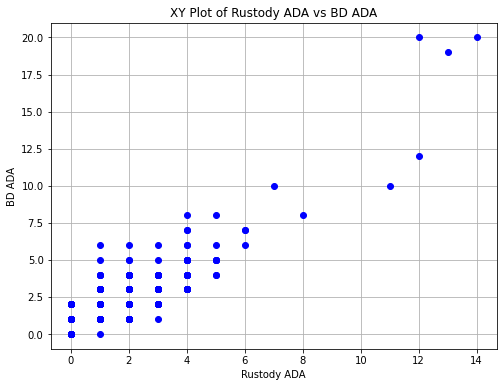

time: 101 ms (started: 2024-01-26 15:31:02 +01:00)


In [51]:
gname = "ADA"
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(Rustody_Data[:,gname].X.todense(), BD_Data[:,gname].X.todense(), 'o', color='blue')  # 'o' represents marker style, you can change it as needed
plt.xlabel( f"Rustody {gname}" )
plt.ylabel( f"BD {gname}" )
plt.title( f"XY Plot of Rustody {gname} vs BD {gname}" )
plt.grid(True)
plt.show()

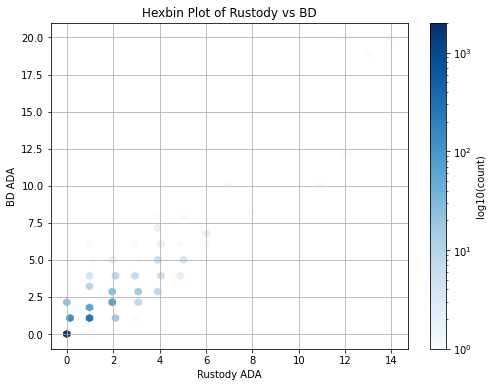

time: 331 ms (started: 2024-01-26 15:31:02 +01:00)


In [52]:
import matplotlib.pyplot as plt

# Assuming Rustody_Data and BD_Data are pandas DataFrames
# Assuming you want to plot the "ADA" column from both DataFrames

# Extracting data from the "ADA" column
rustody_x = np.array(Rustody_Data[:, gname].X.todense()[:,0].transpose()).ravel()
bd_x = np.array(BD_Data[:, gname].X.todense()[:,0].transpose()).ravel()

# Creating the hexbin plot
plt.figure(figsize=(8, 6))
plt.hexbin(rustody_x, bd_x, gridsize=50, cmap='Blues', bins='log')
plt.colorbar(label='log10(count)')
plt.xlabel(f"Rustody {gname}")
plt.ylabel(f"BD {gname}")
plt.title('Hexbin Plot of Rustody vs BD')
plt.grid(True)
plt.show()

# I need to pinch that back to BD

I do not understand how they got this data!